**Introduction**  
Target feature in dataset - **RainTomorrow**, it is binary feature, that takes on two states Yes or No. Thus, in this notebook will be dealt classification problem. Also will be performed data analysis, feature preparation, comparison of built models.

**Independent features:**  
Date - The date of observation

Location - The common name of the location of the weather station

MinTemp - The minimum temperature in degrees celsius

MaxTemp - The maximum temperature in degrees celsius

Rainfall - The amount of rainfall recorded for the day in mm

Evaporation - The so-called Class A pan evaporation (mm) in the 24 hours to 9am

Sunshine - The number of hours of bright sunshine in the day.

WindGustDir - The direction of the strongest wind gust in the 24 hours to midnight

WindGustSpeed - The speed (km/h) of the strongest wind gust in the 24 hours to midnight

WindDir9am - Direction of the wind at 9am

WindDir3pm - Direction of the wind at 3pm

WindSpeed9am - Wind speed (km/hr) averaged over 10 minutes prior to 9am

WindSpeed3pm - Wind speed (km/hr) averaged over 10 minutes prior to 3pm

Humidity9am - Humidity (percent) at 9am

Humidity3pm - Humidity (percent) at 3pm

Pressure9am - Atmospheric pressure (hpa) reduced to mean sea level at 9am

Pressure3pm - Atmospheric pressure (hpa) reduced to mean sea level at 3pm

Cloud9am - Fraction of sky obscured by cloud at 9am. This is measured in "oktas", which are a unit of eigths. It records how many eigths of the sky are obscured by cloud. A 0 measure indicates completely clear sky whilst an 8 indicates that it is completely overcast.

Cloud3pm - Fraction of sky obscured by cloud (in "oktas": eighths) at 3pm. See Cload9am for a description of the values

Temp9am - Temperature (degrees C) at 9am

Temp3pm - Temperature (degrees C) at 3pm

RainToday - Boolean: 1 if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise 0

**Target feature:**  
RainTomorrow - The amount of next day rain in mm. Used to create response variable RainTomorrow. A kind of measure of the "risk".

**Loading libraries**

In [ ]:
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

**First glance at dataset**

In [ ]:
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/HW3/weatherAUS.csv'

df = pd.read_csv(file_path, sep=',')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


Sorting instances by date in case they are not already.

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date', ascending=True)

Extrcated data from feature Date, it was seperated onto 3 other columns Year, Month and Day

In [ ]:
df['Year'] = pd.to_datetime(df['Date']).dt.year
df['Month'] = pd.to_datetime(df['Date']).dt.month
df['Day'] = pd.to_datetime(df['Date']).dt.day
df.drop('Date', axis=1, inplace=True)

**Missing values**

In [ ]:
def print_missing_values_percentages(df):
    for column in df.columns:
        missing_percentage = df[column].isnull().mean() * 100
        print(f"{column}: {missing_percentage:.2f}%")
print_missing_values_percentages(df)

Location: 0.00%
MinTemp: 1.02%
MaxTemp: 0.87%
Rainfall: 2.24%
Evaporation: 43.17%
Sunshine: 48.01%
WindGustDir: 7.10%
WindGustSpeed: 7.06%
WindDir9am: 7.26%
WindDir3pm: 2.91%
WindSpeed9am: 1.21%
WindSpeed3pm: 2.11%
Humidity9am: 1.82%
Humidity3pm: 3.10%
Pressure9am: 10.36%
Pressure3pm: 10.33%
Cloud9am: 38.42%
Cloud3pm: 40.81%
Temp9am: 1.21%
Temp3pm: 2.48%
RainToday: 2.24%
RainTomorrow: 2.25%
Year: 0.00%
Month: 0.00%
Day: 0.00%


Can be seen that features Cloud9am, Cloud3pm, Sunshine, Evaporation are heavily corrupted with missing values. These featurtes will be dropped.   

All other features contain missing values , but in less extent (<= 10%). Features Year, Month, Day do not contain missing data.

In next section will be imputed missing values with strategy: impute missing value with value from previous instance with the same value for feature Location. If there were not such previous instance with valid value, missing value will be imputed from next instance with the same value for feature Location. Such techniques were applied to save the natural dependencies of features, and not to introduce outliers to data by imputing every missing value with median value.

It could happen that after these techniques applied, missing values will still be presented in some features, nothing to do here, they will imputed with respectful median values of features(for numerical features) and with respectful mode values of features(for categorical features).

In [ ]:
columns_drop = ['Cloud9am', 'Cloud3pm', 'Sunshine', 'Evaporation']
df = df.drop(columns=columns_drop)

In [ ]:
def impute_missing_values_by_location(df, location_column):
    for column in df.columns:
        if column != location_column:
            df[column] = df.groupby(location_column)[column].apply(lambda group: group.fillna(method='ffill')).reset_index(level=0, drop=True)
impute_missing_values_by_location(df, "Location")

<ipython-input-59-106cdba5c3f1>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df.groupby(location_column)[column].apply(lambda group: group.fillna(method='ffill')).reset_index(level=0, drop=True)
<ipython-input-59-106cdba5c3f1>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df.groupby(location_column)[column].apply(lambda group: group.fillna(method='ffill')).reset_index(level=0, drop=True)
<ipython-input-59-106cdba5c3f1>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df.groupby(location_column)[column].apply(lambda group: group.fillna(method='ffill')).reset_index(level=0, drop=True)
<ipython-input-59-106cdba5c3f1>:4: FutureWarning: Series.fillna with 'method' is deprecated and w

In [ ]:
def impute_missing_values_by_location_bfill(df, location_column):
    for column in df.columns:
        if column != location_column:
            df[column] = df.groupby(location_column)[column].apply(lambda group: group.fillna(method='bfill')).reset_index(level=0, drop=True)
impute_missing_values_by_location_bfill(df, "Location")

<ipython-input-60-cca29ffe92fe>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df.groupby(location_column)[column].apply(lambda group: group.fillna(method='bfill')).reset_index(level=0, drop=True)
<ipython-input-60-cca29ffe92fe>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df.groupby(location_column)[column].apply(lambda group: group.fillna(method='bfill')).reset_index(level=0, drop=True)
<ipython-input-60-cca29ffe92fe>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df.groupby(location_column)[column].apply(lambda group: group.fillna(method='bfill')).reset_index(level=0, drop=True)
<ipython-input-60-cca29ffe92fe>:4: FutureWarning: Series.fillna with 'method' is deprecated and w

In [ ]:
def fill_missing_values_median_mode(df):
    for column in df.columns:
        if df[column].dtype == 'float64':
            df[column].fillna(df[column].median(), inplace=True)
        elif df[column].dtype == 'object':
            df[column].fillna(df[column].mode()[0], inplace=True)
fill_missing_values_median_mode(df)

<ipython-input-61-16e7c2d63936>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mode()[0], inplace=True)
<ipython-input-61-16e7c2d63936>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

**Encoding**  
Categorical features ("Location", "WindGustDir", "WindDir9am", "WindDir3pm") will be dropped as they are not very correlated with target (was discovered in EDA previous time) and also they conatin a lot of different values , that after one hot enconding would result in expanding feature space of dataset to a very large dimension.

Features RainToday and RainTomorrow will be encoded with rule: "Yes"-> 1 , "No" -> 0, as these features are basically binary.

In [ ]:
categorical_features = ["Location", "WindGustDir", "WindDir9am", "WindDir3pm"]
df = df.drop(columns=categorical_features)

df['RainToday'] = df['RainToday'].map({'Yes': 1, 'No': 0})
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})

As we have seen in EDA there is a relationship betweeen month of the year and amount of rainfalls. So it is better to use this information in models. Month feature will be transformed by applying sin and cos functions. Two new features will be added to daatset after this. Features Year, Day, will no be used in modeling(will be deleted right before modeling). As they do not contain relevant useful information helpful for modeling target feature.

In [ ]:
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
df.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day,Month_sin,Month_cos
45587,8.0,24.3,0.0,30.0,6.0,20.0,68.0,29.0,1019.7,1015.0,14.4,23.6,0,1,2007,11,1,-0.5,0.866025
45588,14.0,26.9,3.6,39.0,4.0,17.0,80.0,36.0,1012.4,1008.4,17.5,25.7,1,1,2007,11,2,-0.5,0.866025
45589,13.7,23.4,3.6,85.0,6.0,6.0,82.0,69.0,1009.5,1007.2,15.4,20.2,1,1,2007,11,3,-0.5,0.866025
45590,13.3,15.5,39.8,54.0,30.0,24.0,62.0,56.0,1005.5,1007.0,13.5,14.1,1,1,2007,11,4,-0.5,0.866025
45591,7.6,16.1,2.8,50.0,20.0,28.0,68.0,49.0,1018.3,1018.5,11.1,15.4,1,0,2007,11,5,-0.5,0.866025


Normalization / standardization will not be applied in this notebook, as further models used are tree-based and tree based ensembles, which do not require standardized or normalized data as an input.

**Data partitioning**  
So to split dataset on training and testing sets was chosen this startegy: all instances recorded before 2016 go to train set, and all instances recorded after go to test set.
As seen below this gives us around 80 percent of all instances in training set and around 20 percent of all instances in test set.
Also the benefit of such strategy is that choronology of recorded instances will be intact.
Also it can be seen that such split preserves proportion of instnces with different target feature values. So, with such a split no direct stratification technique should be used , as we see that proportion of target classes is the same in train and test sets comparing to proportion of target classes in initial dataframe.

In [ ]:
train_data = df[df['Year'] < 2016]
test_data = df[df['Year'] >= 2016]

In [ ]:
train_proportion = len(train_data) / len(df)
test_proportion = len(test_data) / len(df)
print(f"Proportion of train set: {train_proportion:.2%}")
print(f"Proportion of test set: {test_proportion:.2%}")

Proportion of train set: 81.74%
Proportion of test set: 18.26%


In [ ]:
df_proportions = df['RainTomorrow'].value_counts(normalize=True)
print("Df Set:")
print(f"RainTomorrow == 1: {df_proportions.get(1, 0):.2%}")
print(f"RainTomorrow == 0: {df_proportions.get(0, 0):.2%}")

train_proportions = train_data['RainTomorrow'].value_counts(normalize=True)
majority_class = train_data[train_data['RainTomorrow'] == 0]
minority_class = train_data[train_data['RainTomorrow'] == 1]
print(len(majority_class))
print(len(minority_class))
print("\nTrain Set:")
print(f"RainTomorrow == 1: {train_proportions.get(1, 0):.2%}")
print(f"RainTomorrow == 0: {train_proportions.get(0, 0):.2%}")

test_proportions = test_data['RainTomorrow'].value_counts(normalize=True)
print("\nTest Set:")
print(f"RainTomorrow == 1: {test_proportions.get(1, 0):.2%}")
print(f"RainTomorrow == 0: {test_proportions.get(0, 0):.2%}")

Df Set:
RainTomorrow == 1: 22.52%
RainTomorrow == 0: 77.48%
92208
26695

Train Set:
RainTomorrow == 1: 22.45%
RainTomorrow == 0: 77.55%

Test Set:
RainTomorrow == 1: 22.83%
RainTomorrow == 0: 77.17%


**Handling imbalanced data**  
As we see there is clear imbalance of samples with different target values in train set.
Will be performed combination of undersampling and oversampling to deal with this imbalance.
Firtsly will be applied oversampling technique, to reproduce more instances from minor target class(RainTomorrow == 1). The technique chosen for oversampling is simple replicating of existing instances. Then will be applied undersampling of instances from major target class(RainTomorrow == 0).

In [ ]:
majority_class = train_data[train_data['RainTomorrow'] == 0]
minority_class = train_data[train_data['RainTomorrow'] == 1]

minority_oversampled = resample(
    minority_class,
    replace=True,
    n_samples=round(len(majority_class)/3),
    random_state=42
)

train_oversampled = pd.concat([majority_class, minority_oversampled])
train_oversampled = train_oversampled.sort_values(by=['Year', 'Month', 'Day']).reset_index(drop=True)

train_proportions = train_oversampled['RainTomorrow'].value_counts(normalize=True)
print("\nTrain Set:")
print(f"RainTomorrow == 1: {train_proportions.get(1, 0):.2%}")
print(f"RainTomorrow == 0: {train_proportions.get(0, 0):.2%}")
train_oversampled.head()


Train Set:
RainTomorrow == 1: 25.00%
RainTomorrow == 0: 75.00%


,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day,Month_sin,Month_cos
0,14.0,26.9,3.6,39.0,4.0,17.0,80.0,36.0,1012.4,1008.4,17.5,25.7,1,1,2007,11,2,-0.5,0.866025
1,13.7,23.4,3.6,85.0,6.0,6.0,82.0,69.0,1009.5,1007.2,15.4,20.2,1,1,2007,11,3,-0.5,0.866025
2,13.3,15.5,39.8,54.0,30.0,24.0,62.0,56.0,1005.5,1007.0,13.5,14.1,1,1,2007,11,4,-0.5,0.866025
3,7.6,16.1,2.8,50.0,20.0,28.0,68.0,49.0,1018.3,1018.5,11.1,15.4,1,0,2007,11,5,-0.5,0.866025
4,6.2,16.9,0.0,44.0,20.0,24.0,70.0,57.0,1023.8,1021.7,10.9,14.8,0,0,2007,11,6,-0.5,0.866025


So, as can be seen the difference between number of instances from different target variable class were a little bit smoothened. It was have chosen to not use only oversampling to delete this difference but also undersampling, so not to introduce too much of the same instances in training set (to avoid overfitting of future models).

In [ ]:
majority_class = train_oversampled[train_oversampled['RainTomorrow'] == 0]
minority_class = train_oversampled[train_oversampled['RainTomorrow'] == 1]

majority_undersampled = resample(
    majority_class,
    replace=False,
    n_samples=round(len(minority_class)*1.5),
    random_state=42
)
train_balanced = pd.concat([majority_undersampled, minority_class])

train_balanced = train_balanced.sort_values(by=['Year', 'Month', 'Day']).reset_index(drop=True)

train_proportions = train_balanced['RainTomorrow'].value_counts(normalize=True)
print("\nTrain Set:")
print(f"RainTomorrow == 1: {train_proportions.get(1, 0):.2%}")
print(f"RainTomorrow == 0: {train_proportions.get(0, 0):.2%}")


Train Set:
RainTomorrow == 1: 40.00%
RainTomorrow == 0: 60.00%


Now, as can be seen proportion of instances representing negative target class is almost the same as proportion of instances representing positive target class. I have done this so to further use weighting during model training (if there were no disbalance it would not make sense to use weighting) and also not to lose too much important infromation , while deleting instances of target class 0.

**Metrics used to evaluate models**  
To evaluate perfomance of models focus will be on precision, recall and f-1 score for positive target class(RainTomorrow == 1). That is due to the reason, that there is imbalance in test set (more instances with target feature equal to 0). Also it is due to that our primar goal is to predict as accurately rainy tomorrows, there is no privillage for one metric recall or precision, as in equal extent we do not want to see False Negatives and False Positives predictions. That is why we should try to maximize f-1 score, which is basically the harmonic mean of the precision and recall. An optimal tradeoff between precision and recall (positive target class) will be searched.

Following that, while finding best hyperparametrs during tuning, metric used for comparison models with different configurations is f1-score(positive class).

**Modeling**

*Defining X_train, X_test, y_train, y_test sets.*

In [ ]:
y_train = train_balanced['RainTomorrow']
X_train = train_balanced.drop(columns=['RainTomorrow', 'Year', 'Day', 'Month'])

y_test = test_data['RainTomorrow']
X_test = test_data.drop(columns=['Year', "Day", 'Month', 'RainTomorrow'])

**Decision Tree Classifiers**

In [ ]:
def train_decision_tree(X_train, y_train, X_test, y_test, max_depth=None):
    model = DecisionTreeClassifier(max_depth=max_depth)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred, digits=2))
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    return model

In [ ]:
dtc1 = train_decision_tree(X_train, y_train, X_test, y_test, 10)

              precision    recall  f1-score   support

           0       0.89      0.85      0.87     20493
           1       0.56      0.63      0.59      6064

    accuracy                           0.80     26557
   macro avg       0.72      0.74      0.73     26557
weighted avg       0.81      0.80      0.81     26557

Accuracy: 0.80


Out of all classified "Rainy Tomorrows" only 56% are indeed "Rainy Tomorrows", out of all real "Rainy Tomorrows" only 63% are classsified as being "Rainy Tomorrows". F-1 score is equal to relatively moderate value. Such results are obtained with decision tree classifier of maximum depth equal to 10, which is not very large tree. Let's increase this hyperparameter and check whether perfomance can be improved.

Overall, it could be said that for the simplest algorithm regarded in this notebook the perfomance result is pretty good.

Let's increase hyperparameter max_depth (from 10 to 25) and check what changes. We are making model more complex with increasing this hyperparameter.

In [ ]:
dtc2 = train_decision_tree(X_train, y_train, X_test, y_test, 25)

              precision    recall  f1-score   support

           0       0.86      0.81      0.84     20493
           1       0.47      0.56      0.51      6064

    accuracy                           0.75     26557
   macro avg       0.66      0.69      0.67     26557
weighted avg       0.77      0.75      0.76     26557

Accuracy: 0.75


In this case out of all classified positively "Rainy Tomorrows" only 47% are correct, out of all real "Rainy Tomorrows" only 56% are classsified as being "RainyTomorrows". As seen, metrics decreased, F-1 score also decreased (for positive target class). The model became even worse at predicting positive class (RainTomorrow==1). Maybe model overfitted train set, after increasing hyperparametr max_depth to 25. Also, the overall accuracy have dropped, again it suggests that the model probably overfitted training set.

Will be regarded for tuning hyperparametr: max_depth. As it is ,I guess, the most important hyperparametr in Decision Tree model, it controls the complexity of decision tree model. Too high values of it could lead to overfitting and too low values could lead to underfitting. Bigger the value for max_depth bigger tree is going to be built.
No other hyperparameters are regarded, as decision tree is very simple nad does not give much space for amount of hyperparametrs, the most important one is max_depth, changing it could change the perfomance result of model drastically.

In [ ]:
param_grid = {
    'max_depth': [10, 15, 20, 50],
}

model = DecisionTreeClassifier()

scorer = make_scorer(f1_score, pos_label=1)

gs = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

gs.fit(X_train, y_train)

print("Best Parameters:", gs.best_params_)
print("Best F1-Score:", gs.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters: {'max_depth': 10}
Best F1-Score: 0.6754015650303956


After completing hyperparameter tuning, we see that the lowest value for max_depth gives us the best model. Decision Tree was already trained with such hyperparametr. Let's build feature importance plot that corresponds to this tree. Can be concluded that the smallest, the simplest tree gives the best perfomance in our case predicting target variable.

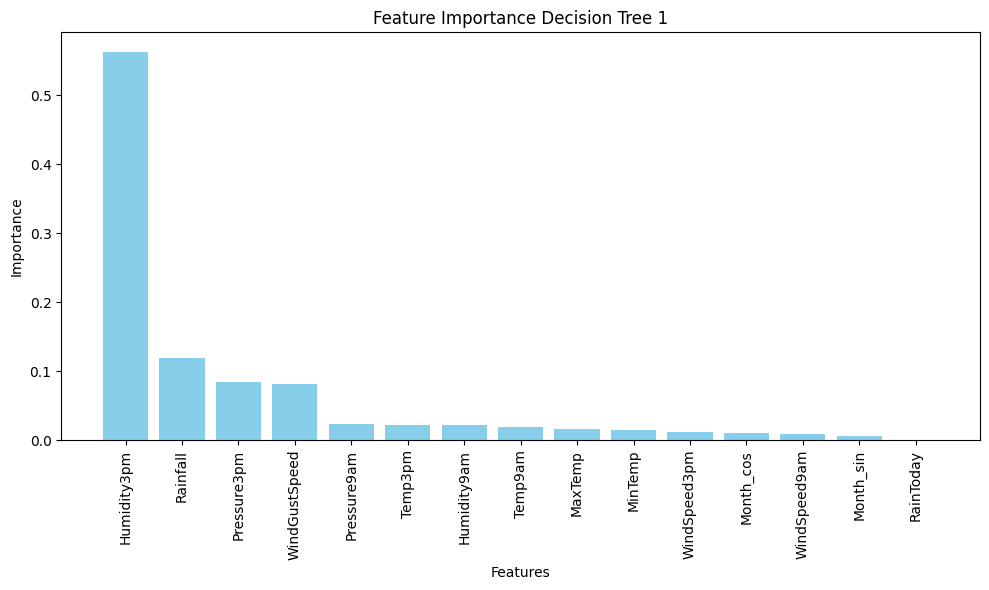

In [ ]:
def plot_feature_importance(model, feature_names):
    importance = model.feature_importances_

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.bar(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xticks(rotation=90)
    plt.title('Feature Importance Decision Tree 1')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

plot_feature_importance(dtc1, X_train.columns)

Can be seen that feature Humidity3PM has the highest effect at target feature. Next most important features are: Rainfall, Pressure3pm, WindGustSpeed.
So, we can conclude that 1) humidity (percent) at 3pm, 2) the amount of rainfall recorded for the day, 3) atmospheric pressure at 3pm and 4) the speed of the strongest wind gust in the 24 hours to midnight are the most important factors that affect whether tomorrow will rain or not. It is hypothesis though, that those factors are the most important. Different models will give us different most important features that affect target. And we still do not know the sign of dependency between each of those feature with target.

Periodical impact on target (from months related features) was not captured by random forests.

Impact on target from feature RainToday was not also captured, used.

**Random Forest Classifier**

In [ ]:
def train_random_forest(X_train, y_train, X_test, y_test, n_estimators=100, max_depth=10):
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, digits=2))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    return model

In [ ]:
rfc1 = train_random_forest(X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.89      0.87      0.88     20493
           1       0.60      0.65      0.62      6064

    accuracy                           0.82     26557
   macro avg       0.74      0.76      0.75     26557
weighted avg       0.83      0.82      0.82     26557

Accuracy: 0.82


Out of all classified "Rainy Tomorrows"(target_est==1) 60% are really "RainyTomorrows"(target==1), out of all real "Rainy Tomorrows"(target==1) only 65% are identified as "Rainy Tomorrows"(target_est==1). F-1 score is relatively a little bit larger than moderate value. Again as for baseline model (max_depth=10, n_estimators=100) results are very good, the baseline model in this case is already pretty complex (because of initial hyperparameters).

In [ ]:
rfc2 = train_random_forest(X_train, y_train, X_test, y_test, n_estimators=200, max_depth=20)

              precision    recall  f1-score   support

           0       0.89      0.90      0.89     20493
           1       0.63      0.61      0.62      6064

    accuracy                           0.83     26557
   macro avg       0.76      0.75      0.76     26557
weighted avg       0.83      0.83      0.83     26557

Accuracy: 0.83


Out of all instances classified as "Rainy Tomorrows" 63% are correct, out of all real "Rainy Tomorrows" only 61% are identified as being "Rainy Tomorrows". F-1 score stayed the same. We can conclude that after increasing hyperparameters values (n_estimators to value of 200 ,baseline was 100) and (max_depth to value of 20, baseline was 10), was reduced number of False Positive mistake and was increased number of False Negative (comparing to previous classifier). The accuracy became higher by one percent.
Cannot be said that this model is better than previous Random Forest (the tradeoff between false positive and false negatives just changed, f1 score stayed the same)

Will be tuned two main hyperparameters of random forest model - n_estimators and max_depth. N_estimators is responsible for overall number of trees included in model. And max_depth is responsible for maximum allowed depth that each tree can reach. These two hyperparameters are the most important , because they directly control the complexity of the model. More we increase each of them , more increases the complexity of random forest.

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20],
}

model = RandomForestClassifier()

scorer = make_scorer(f1_score, pos_label=1)

gs = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

gs.fit(X_train, y_train)

print("Best Parameters:", gs.best_params_)
print("Best F1-Score:", gs.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'max_depth': 10, 'n_estimators': 200}
Best F1-Score: 0.6994737808678488


Best hyperparameters were found: max_depth = 10 and n_estimators = 200. The minimal value for max_depth was chosen and the maximum number estimators was chosen out of parameter values put in search grid. Let's train RF classifier  with these parameters and look at its feature importance plot.

In [ ]:
rfc3 = train_random_forest(X_train, y_train, X_test, y_test, n_estimators=200, max_depth=10)

              precision    recall  f1-score   support

           0       0.89      0.87      0.88     20493
           1       0.60      0.65      0.62      6064

    accuracy                           0.82     26557
   macro avg       0.75      0.76      0.75     26557
weighted avg       0.83      0.82      0.82     26557

Accuracy: 0.82


Metrics of this classifier are just the same as for first random forest classifier.

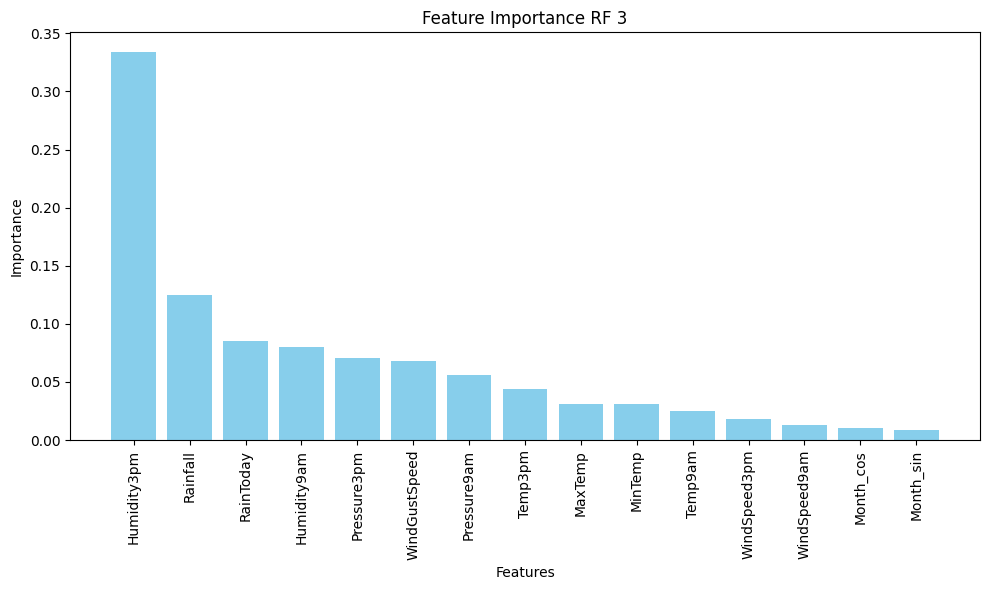

In [ ]:
def plot_feature_importance(model, feature_names):
    importance = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(10, 6))
    plt.bar(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xticks(rotation=90)
    plt.title('Feature Importance RF 3')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

plot_feature_importance(rfc3, X_train.columns)

Still the most important features are 1) humidity (percent) at 3pm, 2) the amount of rainfall recorded for the day (same results as obtained with decision tree). Random forest identified the relationship between feature RainToday and target feature, which was not previously identified by Decision Tree. In simple words, if today rains, it will affect the probability of it raining tomorrow, this relationship is natural. New important feature identified - Humidity 9 am, with higher importance than for features Humidity3pm, WindGustSpeed(they have approximately the same importance values as had before in Decision Tree). Overall , random forest distributed importance across all features, comparing to decision tree (which basically almost zeroed importance of most features), so new important features were identified.

Periodical impact on target (from months related features) was not captured by random forests.


**XGBoost classifier**

Weighting will be applied to untuned XGBoost models. Weighting will be applied so to give equal weights to all samples representing negative and positive target feature. Tuned XGBoost will be trained without weighting.
During training of XGBoost will be used "logloss" loss function , as we are dealing here with binary classification problem.

In [ ]:
def train_xgboost(X_train, y_train, X_test, y_test, max_depth=3, n_estimators=100, learning_rate=0.1):
    pos_class_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    model = XGBClassifier(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=pos_class_weight)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred, digits=2))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    return model

In [ ]:
xgb_model_1 = train_xgboost(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:52:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.91      0.79      0.85     20493
           1       0.51      0.74      0.60      6064

    accuracy                           0.78     26557
   macro avg       0.71      0.77      0.73     26557
weighted avg       0.82      0.78      0.79     26557

Accuracy: 0.78


Can be seen that precision for positive class is 51% and recall is 74%. Meaning that the False Positive error is high for positive class and False Negative is pretty low. So, classifier is pretty good at identifying real Rainy Tomorrows, but makes a lot of mispredictions classifying almost 50% of tomorrows as rainy incorrectly. That happened probably because we used weighting in this model, now model treats two classes equaly.

In [ ]:
xgb_model_2 = train_xgboost(X_train, y_train, X_test, y_test, max_depth=5, n_estimators=200, learning_rate=0.05)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.92      0.80      0.85     20493
           1       0.53      0.75      0.62      6064

    accuracy                           0.79     26557
   macro avg       0.72      0.78      0.74     26557
weighted avg       0.83      0.79      0.80     26557

Accuracy: 0.79


After incresing hyperparameter values: max_depth to 5, n_estimators to 200 and decreasing learning rate to 0.05, classifier did better job. Precision went higher, as well recall for positive class. F1 score also became higher, which suggest that choosing hyperparameter change direction was correct.

In [ ]:
xgb_model_3 = train_xgboost(X_train, y_train, X_test, y_test, max_depth=5, n_estimators=300, learning_rate=0.05)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:48:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.92      0.80      0.86     20493
           1       0.53      0.75      0.62      6064

    accuracy                           0.79     26557
   macro avg       0.72      0.78      0.74     26557
weighted avg       0.83      0.79      0.80     26557

Accuracy: 0.79


After increasing number of estimators from 200 to 300(all other hyperparametrs are the same as were for 2 XGBoost classifier), no change can be seen suggesting that XGBoost found optimal solution with previous hyperparameter settings (max_depth=5, n_estimators = 200, learning_rate=0.05).

For XGBoost will be tuned hyperparameters: max_depth, n_estimators (the reason for choosing them is the same as in previous cases for Decision Trees and Random Forests). Also will be tuned learning_rate hyperparameter , which affects the weight assigned to each tree during training, as well it helps to prevent algorithm from overfitting. Again, those could be considered as one of the most important hyperparameters in XGBoost model.

In [ ]:
param_grid = {
    'max_depth': [3, 5, 10],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.05, 0.01]
}

pos_class_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=pos_class_weight)

scorer = make_scorer(f1_score, pos_label=1)

gs = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

gs.fit(X_train, y_train)

print("Best Parameters:", gs.best_params_)
print("Best F1-Score:", gs.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:01:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best F1-Score: 0.7321793119970769


In [ ]:
xgb_model_4 = train_xgboost(X_train, y_train, X_test, y_test, max_depth=5, n_estimators=200, learning_rate=0.1)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:02:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.92      0.80      0.86     20493
           1       0.53      0.75      0.62      6064

    accuracy                           0.79     26557
   macro avg       0.72      0.78      0.74     26557
weighted avg       0.83      0.79      0.80     26557

Accuracy: 0.79


Tuned XGBoost classifier (with weighting) showed the same results as previous two models. Let's train the same as tuned XGBoost classifier , but without weighting, to see if there is difference in perfomance.

In [ ]:
xgBoostNoWeight = XGBClassifier(max_depth=5, n_estimators=200, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
xgBoostNoWeight.fit(X_train, y_train)
y_pred = xgBoostNoWeight.predict(X_test)

print(classification_report(y_test, y_pred, digits=2))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:06:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.90      0.86      0.88     20493
           1       0.59      0.67      0.63      6064

    accuracy                           0.82     26557
   macro avg       0.75      0.77      0.76     26557
weighted avg       0.83      0.82      0.82     26557

Accuracy: 0.82


The difference is present, overall XGBoost classifier showed by 0.01 unit higher f1-score, comparing to tuned XGBoost with weighting. Though recall for positive class decreased. In our case we assume that this XGBoost classifier did better job, as f1 score is higher for him. But in general, if we cared more about recall of positive target class, we would choose tuned, with weighting XGBoost.

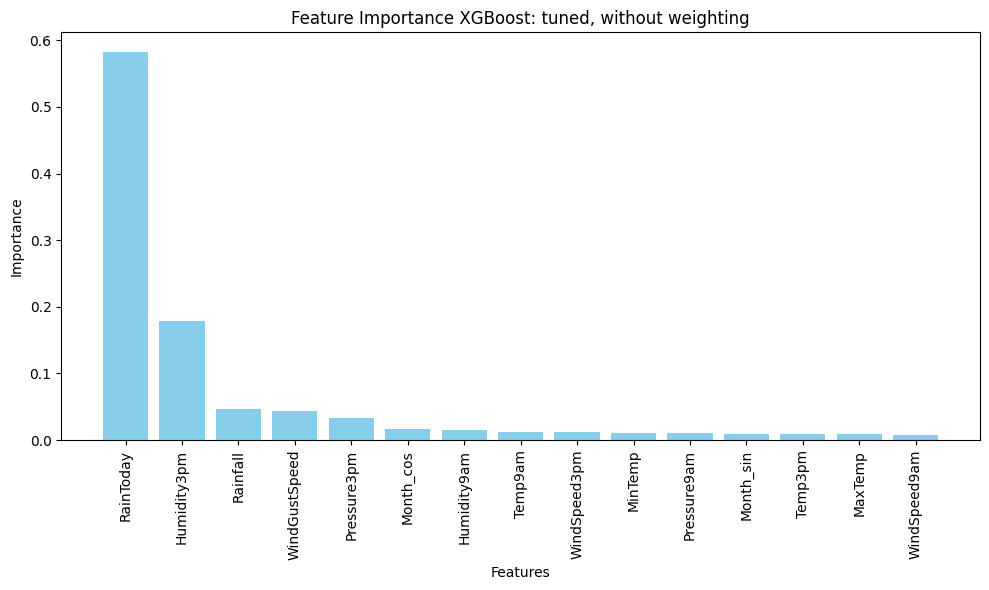

In [ ]:
def plot_feature_importance(model, feature_names):
    importance = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(10, 6))
    plt.bar(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xticks(rotation=90)
    plt.title('Feature Importance XGBoost: tuned, without weighting')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

plot_feature_importance(xgb_model_2, X_train.columns)

XGBoost model as can be seen relies when predicting target mostly on the feature RainToday. Other somewhat important features are Humidity3pm, Rainfall, WindGustSpeed, Pressure3pm. All other features contribute very little while making predictions, XGBoost identified them as unimportant. The high impact of feature RainToday on predictions for RainTomorrow is very natural, explainable and expected, as noted before in part for random forests. It probably much more likely that tomorrow is going to rain , if it was today.  
The importance plot for XGBoost model is differs severely from importnace plot for Decision Tree model and Random Forest model.

Periodical impact on target (from months related features) was not captured by XGBoost.

**Conclusion**

*Results of previous work*  
Best Logistic Regression(penalty='elasticnet', l1_ratio=0.5, weighted):  
precision=0.59, recall=0.65, f1-score=0.62(for positive class)

Best KNN(n_neigbours=10):   
precision=0.5, recall=0.5, f1-score=0.5 (for positive class)

Best Naive Baes(weighted):   
precision=,0.34 recall=0.71, f1-score=0.46 (for positive class)

Best SVM (kernel='rbf'):     
precision=0.45, recall=0.44, f1-score=0.45 (for positive class)

*Results of current work*     
Best Decision Tree (max_depth=10):   
precision=0.56, recall=0.63, f1-score=0.59 (for positive class)

Best Random Forest (n_estimators=100, max_depth=10):  
precision=0.6, recall=0.65, f1-score=0.62 (for positive class)

Best XGBoost (max_depth=5, n_estimators=200, learning_rate=0.1, NON weighted):  
precision=0.59, recall=0.67, f1-score=0.63 (for positive class)

As can be seen, f1-score is equal to 0.62 (for positive class) for models: Logistic Regression, Random Forest.
The best model XGBoost has the f1-score equal to 0.63, which makes it the best classifier out of all presented in this notebook and out of all presented in previous notebook.

---

Also we have seen that such features could be cosidered as very important in our dataset for predicting target, most influencial: RainToday, Humidity3pm, Rainfall. It is derived from built feature importance plots of each classifier.

---

Also we have seen than random forests make use of fairly all features for modeling (some with less weight, some with higher, but all features are engaged). Which is different for decision tree and xgboost models, as they can zero some features importance at all or almost at all, which was seen from feature importance plots.
